In [1]:
import skimage      
from skimage import io, filters
from skimage import filters
from scipy.ndimage import sobel, interpolation
import skimage.color as color
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.linalg import eig
import cv2
import time


In [2]:
def extract_frame_cv2(video_path, time_ms, output_image_path):

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError("Could not open video file")


    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_number = int((time_ms / 1000) * fps)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    success, frame = cap.read()


    cv2.imwrite(output_image_path, frame)
    cap.release()

In [3]:
def read_video(file_path):
    cap = cv2.VideoCapture(file_path)
    frames = []

    start_time_milliseconds = 200
    cap.set(cv2.CAP_PROP_POS_MSEC, start_time_milliseconds)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)) 
    cap.release()
    
    return frames

In [4]:
video_path = 'redBall.mp4'  
time_ms = 200 
output_image_path = 'frame.jpg'  

extract_frame_cv2(video_path, time_ms, output_image_path)

In [5]:
frame = io.imread('frame.jpg')
gray_frame = color.rgb2gray(frame)

In [6]:

sigmaI = 1
sigmaD = 0.7

def gaussDeriv2D(sigma):

    min = -np.ceil(3 * sigma)
    max = np.ceil(3 * sigma)

    xRange = np.arange(min, max + 1)    
    yRange = np.arange(min, max +1)

    X = np.array([[x for x in xRange] for y in yRange])
    Y =  np.array([[x for x in xRange] for y in yRange]).T

    Gx = ((X - 0) / (2 * np.pi * sigma**4)) * np.exp(-((X - 0)**2 + (Y - 0)**2) / (2 * sigma**2))
    Gy = ((Y - 0) / (2 * np.pi * sigma**4)) * np.exp(-((X - 0)**2 + (Y - 0)**2) / (2 * sigma**2))
    return Gx, Gy

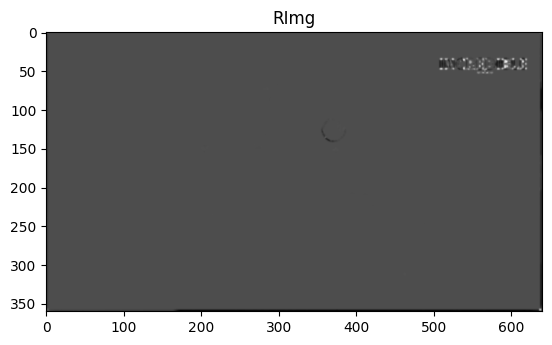

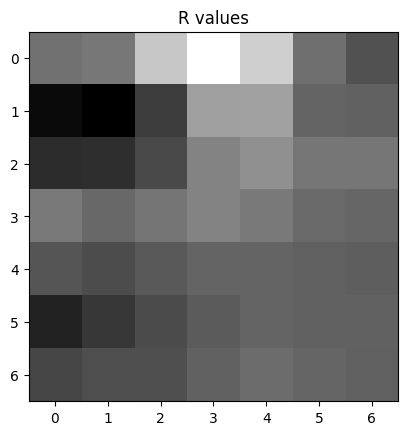

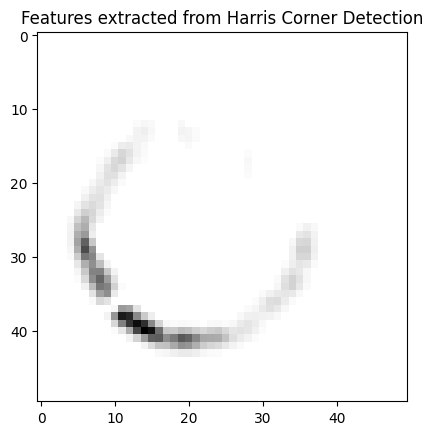

0.0


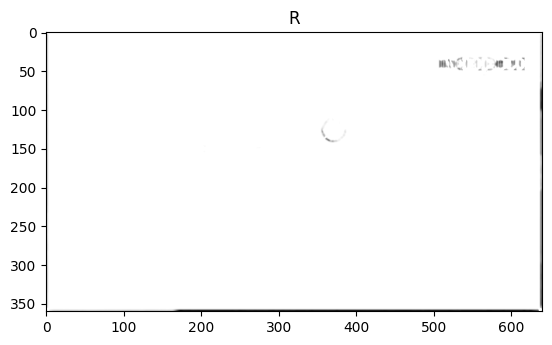

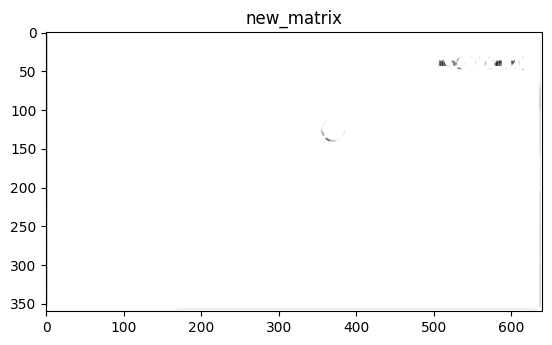

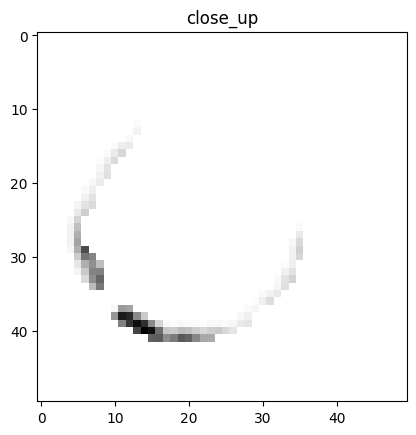

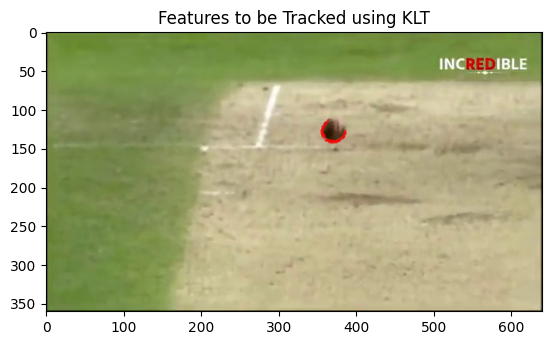

129


In [7]:

Gx, Gy = gaussDeriv2D(sigmaD)

Ix = scipy.ndimage.convolve(gray_frame, Gx, mode='nearest')
Iy = scipy.ndimage.convolve(gray_frame, Gy, mode='nearest')

IxIx = Ix * Ix
IyIy = Iy * Iy
IxIy = Ix * Iy

Ix2 = scipy.ndimage.gaussian_filter(IxIx, sigmaI, mode='nearest', truncate=3)
Iy2 = scipy.ndimage.gaussian_filter(IyIy, sigmaI, mode='nearest', truncate=3)
IxIy = scipy.ndimage.gaussian_filter(IxIy, sigmaI, mode='nearest', truncate=3)

a = 0.05

RImg = (Ix2 * Iy2 - IxIy**2) - a * (Ix2 + Iy2)**2
plt.title('RImg')
plt.imshow(RImg, cmap='gray')
plt.show()

rValues = RImg[15:22, 15:22] 
plt.title('R values')
plt.imshow(rValues, cmap='gray')
plt.show()


threshold = -4.96168452402024e-07
RImg[RImg >= threshold] = 0

new = RImg[100:150, 350:400]
plt.imshow(new, cmap='gray')
plt.title('Features extracted from Harris Corner Detection')
plt.show()
print(new[12,20])



plt.imshow(RImg, cmap='gray')
plt.title('R')
plt.show()


ballFeaturePoints = []

h = RImg.shape[0]
w = RImg.shape[1]
points = []

new_matrix = np.zeros((h, w))

# supression
for y in range(h - 3 + 1):
    for x in range(w - 3 + 1):
        region = RImg[y:y + 3, x:x + 3]
        maxPoint = np.max(region)
        count = 0

        for i in region.flatten():
            if i == maxPoint:
                count += 1

        if count == 1:
            new_matrix[y, x] = RImg[y, x]
            points.append((y, x))


plt.imshow(new_matrix, cmap='gray')
plt.title('new_matrix')
plt.show()

threshold2 = -4.96168452402024e-07


new_matrix[new_matrix >= threshold2] = 0
close_up= new_matrix[100:150, 350:400]
plt.imshow(close_up, cmap='gray')
plt.title('close_up')
plt.show()


# extract the features of the ball
for y in range(RImg.shape[0]):
    for x in range(RImg.shape[1]):
        if new_matrix[y, x] != 0:
            if (y >= 100 and y < 150) and (x >= 350 and x < 400):
                ballFeaturePoints.append((y, x))

plt.imshow(frame, cmap='gray')
plt.plot([y[1] for y in ballFeaturePoints], [x[0] for x in ballFeaturePoints], 'r.', markersize=0.5)  
plt.title('Features to be Tracked using KLT')
plt.show()

print(len(ballFeaturePoints))



In [8]:
def downsample(frame, factor, sigmaL=1):
    scipy.ndimage.gaussian_filter(frame, sigmaL, mode='nearest', truncate=3)
    return frame[::factor, ::factor]

In [9]:
def create_pyramid(frame, levels=4):
    pyramid = [frame]
    for i in range(levels):
        pyramid.append(downsample(pyramid[i], 2))
    return pyramid

In [10]:
def compute_gradients(frame):
    Ix = filters.sobel_h(frame)
    Iy = filters.sobel_v(frame)
    return Iy, Ix

In [11]:
# KLT optic flow algorithm
def track_point(y, x, Iy1, Ix1, It, window_size):
    A = []
    b = []
    half_window = window_size // 2 
    
    for dy in range(-half_window, half_window + 1):
        for dx in range(-half_window, half_window + 1):
            px, py = x + dx, y + dy
        
            if 0 <= py < Iy1.shape[0] and 0 <= px < Ix1.shape[1]:
                A.append([Iy1[py, px], Ix1[py, px]])
                b.append(-It[py, px])
    
    A = np.array(A)
    b = np.array(b)
    
    if A.shape[0] < 2 or A.shape[0] != b.shape[0]:
        return (0, 0)
    
    uv = np.linalg.lstsq(A, b, rcond=None)[0]
    return uv


In [12]:
def track_points_in_frame(frame1, frame2, points_to_track, window_size):
    Iy1, Ix1 = compute_gradients(frame1)
    It = frame2 - frame1
    displacements = [track_point(y, x, Iy1, Ix1, It, window_size) for y, x in points_to_track]
    updated_points = [(y + int(v), x + int(u)) for (y, x), (v, u) in zip(points_to_track, displacements)]
    return updated_points

In [13]:
def visualize_tracking(frame, points, frame_number):
    for y, x in points:
        cv2.circle(frame, (int(x), int(y)), 2, (0, 0, 255), -1)
    cv2.imshow('Tracking', frame)
    window_title = "Frame Number: " + str(frame_number)
    cv2.setWindowTitle('Tracking', window_title)

In [14]:

frames = read_video('redBall.mp4')
windowSize = 5
first_frame = frames[0]
positions = []

for i in range(len(frames) - 1):
    
    visualize_tracking(frames[i], ballFeaturePoints, i+1)
    updated_points = track_points_in_frame(frames[i], frames[i + 1], ballFeaturePoints, windowSize)
    positions.append(updated_points)
    ballFeaturePoints = updated_points

    if cv2.waitKey(1000) == ord('q'):
        break

left_count = 0
right_count = 0

# figure out left or right spin
for i in range(len(positions[0])):
    if positions[-1][i][0] < positions[25][i][0]:
        right_count += 1
    else:   
        left_count += 1

if left_count > right_count:
    print(f"Left spin: {left_count}")
else:
    print(f"Right spin: {right_count}")

cv2.destroyAllWindows() 

/var/folders/5z/bph881dn1jjcn_8ppsxxy59m0000gn/T/ipykernel_82820/3994059957.py:13: RuntimeWarning: overflow encountered in scalar negative
  b.append(-It[py, px])


Left spin: 125


: 